# Aggregate extraced time across multiple traces

1. Input parameters: directory with JSON traces, trace name pattern, (multiple) event patterns.  
   a. In trace name pattern, use one group for the varying parameter value (MBS).
2. For each event pattern, extract event time from all traces one by one using parseOneTrace script.
3. Aggregate values into one DF along with the varying parameter value extracted from the trace filename.


In [1]:
import os
import pandas as pd
import subprocess
import re
import matplotlib
from matplotlib import pyplot as plt

## Set input parameters

In [8]:
logdir = 'logs/DL.cont/traces/20200803'
trace_name_pattern = 'nsys_trace_([0-9]+).json'
event_patterns = ['.*prediction.*','.*WD pass.*', '.*optimizer update.*', '.*iteration.*']

## Read trace files

In [9]:
list_command = "ls -1 " + logdir
files = []
param_values = []
proc = subprocess.Popen(list_command.split(" "),
                        stdout=subprocess.PIPE,
                        stderr=subprocess.STDOUT,
                        encoding='utf8')
for line in iter(proc.stdout.readline, ''):
    line = line.strip(" \n")
    m = re.match(trace_name_pattern, line)
    if m:
        files.append(os.path.abspath(os.path.join(logdir, line)))
        param_values.append(m.group(1))

print('{} files in {}'.format(len(files), logdir))
print(tuple(zip(files,param_values)))

20 files in logs/DL.cont/traces/20200803
(('/Users/peterbryzgalov/work/ML/nsystraceparser/logs/DL.cont/traces/20200803/nsys_trace_10.json', '10'), ('/Users/peterbryzgalov/work/ML/nsystraceparser/logs/DL.cont/traces/20200803/nsys_trace_11.json', '11'), ('/Users/peterbryzgalov/work/ML/nsystraceparser/logs/DL.cont/traces/20200803/nsys_trace_12.json', '12'), ('/Users/peterbryzgalov/work/ML/nsystraceparser/logs/DL.cont/traces/20200803/nsys_trace_13.json', '13'), ('/Users/peterbryzgalov/work/ML/nsystraceparser/logs/DL.cont/traces/20200803/nsys_trace_14.json', '14'), ('/Users/peterbryzgalov/work/ML/nsystraceparser/logs/DL.cont/traces/20200803/nsys_trace_15.json', '15'), ('/Users/peterbryzgalov/work/ML/nsystraceparser/logs/DL.cont/traces/20200803/nsys_trace_16.json', '16'), ('/Users/peterbryzgalov/work/ML/nsystraceparser/logs/DL.cont/traces/20200803/nsys_trace_17.json', '17'), ('/Users/peterbryzgalov/work/ML/nsystraceparser/logs/DL.cont/traces/20200803/nsys_trace_18.json', '18'), ('/Users/pete

In [16]:
results = None
# Set to True to convert json traces to CSV
convert_traces=True
for param, tracefile in zip(param_values, files):
    events = ' '.join(event_patterns)
    if convert_traces:
        # Run
        # python3 parseOneTrace.py -f $tracefile --events $events
        command = 'python3 parseOneTrace.py -f {} --events {}'.format(tracefile, events)
        print(command)
        p = subprocess.run(command.split(' '), stdout=subprocess.PIPE, stderr=subprocess.PIPE,
                           bufsize=0, shell=False)
        if p.returncode == 0:
            if p.stdout:
                print(p.stdout.decode('utf-8'))
            print('Finished OK')
        else:        
            print(p.stdout.decode('utf-8'))
            print('ERROR')
            print(p.stderr.decode('utf-8'))
    # Read data from CSV file
    directory = os.path.dirname(tracefile)
    csvfile = ('').join(os.path.basename(
        tracefile).split('.')[:-1])  # Filename without extension
    csvfile = csvfile + '.csv'
    csvfile = os.path.join(directory, csvfile)
    print('Reading {}'.format(csvfile))    
    df_ = pd.read_csv(csvfile)
    df_['param'] = param
#     display(df_.head())
    if results is None:
        results = df_
    else:
        results = results.append(df_, ignore_index=True)
        
results.sample(n=8)

python3 parseOneTrace.py -f /Users/peterbryzgalov/work/ML/nsystraceparser/logs/DL.cont/traces/20200803/nsys_trace_10.json --events .*prediction.* .*WD pass.* .*optimizer update.* .*iteration.*
Extracting data from a JSON trace file. v.0.03.
Reading /Users/peterbryzgalov/work/ML/nsystraceparser/logs/DL.cont/traces/20200803/nsys_trace_10.json
Read 13054 rows from /Users/peterbryzgalov/work/ML/nsystraceparser/logs/DL.cont/traces/20200803/nsys_trace_10.json.
NVTX
      Type  NvtxEvent.Type  ...     start       end
280   59.0            59.0  ...  1.734937  5.354982
2210  34.0            34.0  ...  5.356086       NaN
2211  34.0            34.0  ...  5.356093       NaN
2219  59.0            59.0  ...  5.571515  5.718184
2229  59.0            59.0  ...  5.573157  5.645112

[5 rows x 11 columns]
Matched Events:
       type     id                                              value
14   String   14.0  QUADD_CUDA_CONFIG=/tmp/injection_config_8db48b...
16   String   16.0  LOGNAME=peter USER=peter 

Extracting data from a JSON trace file. v.0.03.
Reading /Users/peterbryzgalov/work/ML/nsystraceparser/logs/DL.cont/traces/20200803/nsys_trace_15.json
Read 13128 rows from /Users/peterbryzgalov/work/ML/nsystraceparser/logs/DL.cont/traces/20200803/nsys_trace_15.json.
NVTX
      Type  NvtxEvent.Type  ...     start       end
285   59.0            59.0  ...  1.814666  5.562507
2215  34.0            34.0  ...  5.563558       NaN
2216  34.0            34.0  ...  5.563566       NaN
2223  59.0            59.0  ...  5.839509  6.012271
2233  59.0            59.0  ...  5.841773  5.914782

[5 rows x 11 columns]
Matched Events:
       type     id                                              value
14   String   14.0  QUADD_CUDA_CONFIG=/tmp/injection_config_6327fa...
16   String   16.0  LOGNAME=peter USER=peter PWD=/host/nsystracepa...
17   String   17.0  LOGNAME=peter USER=peter NVIDIA_VISIBLE_DEVICE...
31   String   31.0  OLDPWD=/host SHELL=/bin/bash CUDA_VISIBLE_DEVI...
101  String  101.0  _Z42cunn

Extracting data from a JSON trace file. v.0.03.
Reading /Users/peterbryzgalov/work/ML/nsystraceparser/logs/DL.cont/traces/20200803/nsys_trace_20.json
Read 13134 rows from /Users/peterbryzgalov/work/ML/nsystraceparser/logs/DL.cont/traces/20200803/nsys_trace_20.json.
NVTX
      Type  NvtxEvent.Type  ...     start       end
287   59.0            59.0  ...  1.808673  5.535899
2217  34.0            34.0  ...  5.536977       NaN
2218  34.0            34.0  ...  5.536983       NaN
2225  59.0            59.0  ...  5.900168  6.125082
2235  59.0            59.0  ...  5.902569  5.987051

[5 rows x 11 columns]
Matched Events:
       type     id                                              value
14   String   14.0  QUADD_CUDA_CONFIG=/tmp/injection_config_1d9c0f...
16   String   16.0  LOGNAME=peter USER=peter PWD=/host/nsystracepa...
17   String   17.0  LOGNAME=peter USER=peter NVIDIA_VISIBLE_DEVICE...
31   String   31.0  OLDPWD=/host SHELL=/bin/bash CUDA_VISIBLE_DEVI...
102  String  102.0  _Z42cunn

Extracting data from a JSON trace file. v.0.03.
Reading /Users/peterbryzgalov/work/ML/nsystraceparser/logs/DL.cont/traces/20200803/nsys_trace_25.json
Read 13249 rows from /Users/peterbryzgalov/work/ML/nsystraceparser/logs/DL.cont/traces/20200803/nsys_trace_25.json.
NVTX
      Type  NvtxEvent.Type  ...     start       end
288   59.0            59.0  ...  1.862481  5.497466
2218  34.0            34.0  ...  5.498650       NaN
2219  34.0            34.0  ...  5.498662       NaN
2224  59.0            59.0  ...  5.824441  6.094643
2235  59.0            59.0  ...  5.833575  5.921184

[5 rows x 11 columns]
Matched Events:
       type     id                                              value
14   String   14.0  QUADD_CUDA_CONFIG=/tmp/injection_config_1f9e89...
16   String   16.0  LOGNAME=peter USER=peter PWD=/host/nsystracepa...
17   String   17.0  LOGNAME=peter USER=peter NVIDIA_VISIBLE_DEVICE...
31   String   31.0  OLDPWD=/host SHELL=/bin/bash CUDA_VISIBLE_DEVI...
100  String  100.0  _Z42cunn

,NVTX,API event,iteration,duration,param
177,"Iteration 3,BWD pass",cudnnConvolutionBackwardData,3,0.029502,16
204,"Iteration 1,BWD pass",cudnnConvolutionBackwardFilter,1,0.036925,17
342,"Iteration 1,FWD pass",cudnnConvolutionForward,1,0.037956,22
358,"Iteration 2,BWD pass",cudnnBatchNormalizationBackwardEx,2,0.018845,23
265,"Iteration 1,BWD pass",cublasSgemm_v2,1,0.000136,20
460,"Iteration 2,BWD pass",cudnnBatchNormalizationBackwardEx,2,0.005867,7
74,"Iteration 3,FWD pass",cudnnConvolutionForward,3,0.022658,12
455,"Iteration 2,BWD pass",cublasSgemm_v2,2,0.000145,7


In [11]:
times = results.copy()
print('API events:',times['API event'].unique())
# Count duplicate entries
times_ = times.groupby(['NVTX', 'iteration', 'API event', 'param'], as_index=False).count()
display(times_[times_['duration'] > 1])
# No duplicates
# SUM time of the same API events in each iteration
times = times.groupby(['iteration', 'API event', 'param'], as_index=False).sum()
display(times.sample(n=5))
# Average between iterations
# Check number of entries
times_ = times.groupby(['API event', 'param'], as_index=False).count()
display(times_[times_['duration'] != 5])
# Have only one iteration for mbs50
times = times.groupby(['API event', 'param'], as_index=False).mean()
times['param'] = times['param'].astype(int)
display(times.head())

API events: ['cublasSgemmStridedBatched' 'cublasSgemm_v2'
 'cudnnBatchNormalizationBackwardEx' 'cudnnConvolutionBackwardData'
 'cudnnConvolutionBackwardFilter'
 'cudnnBatchNormalizationForwardTrainingEx' 'cudnnConvolutionForward']


,NVTX,iteration,API event,param,duration


,iteration,API event,param,duration
11,1,cublasSgemmStridedBatched,21,0.004707
364,3,cudnnConvolutionBackwardData,14,0.025519
53,1,cudnnBatchNormalizationBackwardEx,23,0.019337
100,1,cudnnConvolutionBackwardFilter,10,0.024815
42,1,cudnnBatchNormalizationBackwardEx,12,0.009936


,API event,param,iteration,duration
0,cublasSgemmStridedBatched,10,3,3
1,cublasSgemmStridedBatched,11,3,3
2,cublasSgemmStridedBatched,12,3,3
3,cublasSgemmStridedBatched,13,3,3
4,cublasSgemmStridedBatched,14,3,3
...,...,...,...,...
135,cudnnConvolutionForward,25,3,3
136,cudnnConvolutionForward,6,3,3
137,cudnnConvolutionForward,7,3,3
138,cudnnConvolutionForward,8,3,3


,API event,param,iteration,duration
0,cublasSgemmStridedBatched,10,2,0.001554
1,cublasSgemmStridedBatched,11,2,0.001698
2,cublasSgemmStridedBatched,12,2,0.002987
3,cublasSgemmStridedBatched,13,2,0.002878
4,cublasSgemmStridedBatched,14,2,0.002962


API event,cublasSgemmStridedBatched,cublasSgemm_v2,cudnnBatchNormalizationBackwardEx,cudnnBatchNormalizationForwardTrainingEx,cudnnConvolutionBackwardData,cudnnConvolutionBackwardFilter,cudnnConvolutionForward
param,,,,,,,
21,0.004711,0.000214,0.017202,0.010403,0.037096,0.043923,0.037344
22,0.004798,0.000214,0.018016,0.010847,0.038128,0.045564,0.037897
23,0.005319,0.000228,0.018994,0.011508,0.042132,0.049807,0.042715
24,0.005065,0.000215,0.019596,0.011747,0.040848,0.049199,0.040739
25,0.006330,0.000220,0.020414,0.012188,0.045346,0.051045,0.041555


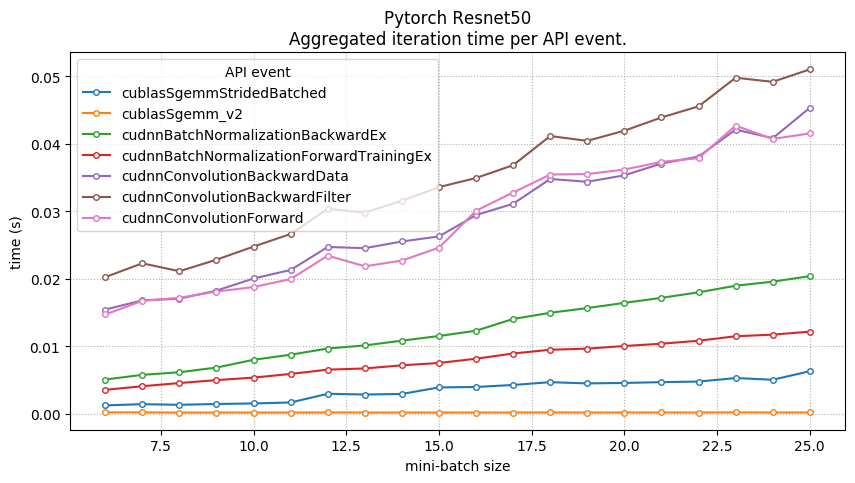

In [7]:
timesT = times.pivot_table(columns='API event', index='param', values='duration',aggfunc='sum')
# Use MBS 5-40
timesT = timesT.loc[:40]
display(timesT.tail())
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
timesT.plot(marker='o', ms=4, mfc='w', ax=ax)
ax.grid(ls=':', which='major')
ax.grid(ls=':', lw=0.5, which='minor')
ax.set_xlabel('mini-batch size')
ax.set_ylabel('time (s)')
plt.title('Pytorch Resnet50\nAggregated iteration time per API event.')
plt.show()

In [16]:
# Group API events by type
def getType(e):
    types = {'FC': 'sgemm_v2',
             'conv': 'conv',
             'BN': 'batchnormalization'}
    for k, v in types.items():
        m = re.search(v, e.lower())
        if m is not None:
            return k
    return 'other'

In [17]:
# Sum time for same type events
times['type'] = times['API event'].apply(getType)
times = times[(times['type'] != 'other') & (times['param'] != 50)]
times = times.groupby(['type', 'param'], as_index=False).sum()
times['param'] = times['param'].astype(int)
times.head()
times.sample(n=7)

,type,param,iteration,duration
6,BN,12,6,0.034357
12,FC,6,3,0.000419
30,conv,20,9,0.214981
9,BN,30,6,0.084773
21,FC,40,3,0.000663
17,FC,12,3,0.000453
20,FC,30,3,0.000463


In [18]:
timesT = times.pivot_table(columns='type', index='param', values='duration')
timesT.head()

type,BN,FC,conv
param,,,
5,0.017407,0.000460,0.084629
6,0.017144,0.000419,0.081668
7,0.019659,0.000418,0.091030
8,0.023046,0.000419,0.100493
9,0.025450,0.000424,0.110049


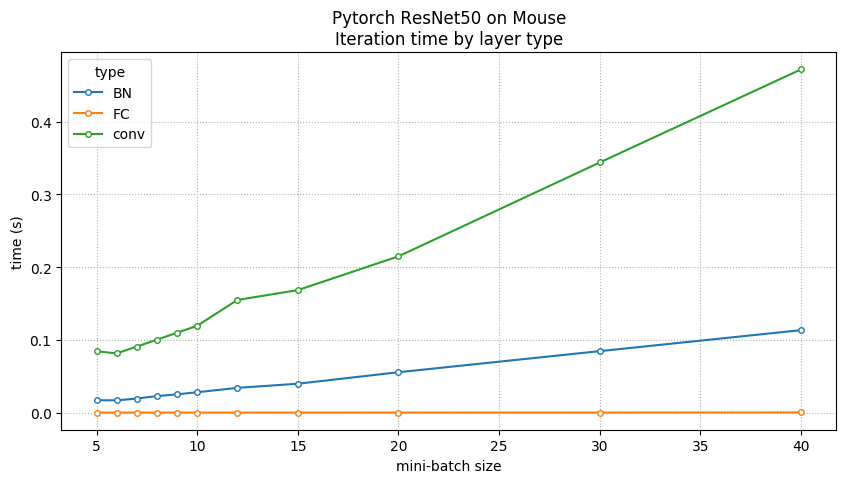

In [19]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
timesT.plot(marker='o', ms=4, mfc='w', ax=ax)
ax.grid(ls=':', which='major')
ax.grid(ls=':', lw=0.5, which='minor')
ax.set_xlabel('mini-batch size')
ax.set_ylabel('time (s)')
plt.title('Pytorch ResNet50 on Mouse\nIteration time by layer type')
plt.show()